# Homework 05

## Assignment 2 CIFAR-10 Classification

In [1]:
# general imports
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

C:\Users\berit\AppData\Local\Continuum\miniconda3\envs\iannwtf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.1 Prepare dataset

* information about the data
    * dataset size: 60 000 images (50 000 train, 10 000 test) 
    * classes: 10 classes (each has 6000 images - that means an even distribution of classes which is important for the informative value of e.g. accuracy scores); given in int64 
        * classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck	(4 inanimates, 6 animates)									
        * classes are completely mutually exclusive; e.g. there is no overlap between automobiles and trucks 
    * type of data: 32x32 colour images 
    * image size: shape=(32, 32, 3), dtype=uint8
    * color channels: 3 
     
    
* load data and preprocess

* visualize data example 

In [2]:
# loading data
(train_ds, test_ds), ds_info = tfds.load('cifar10', split =['train', 'test'],
                                               as_supervised =True , with_info = True )

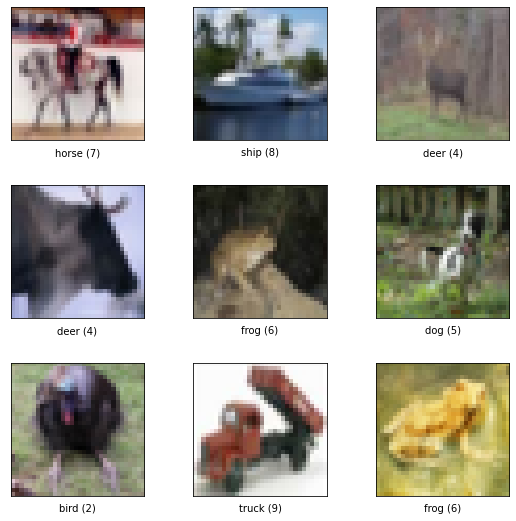

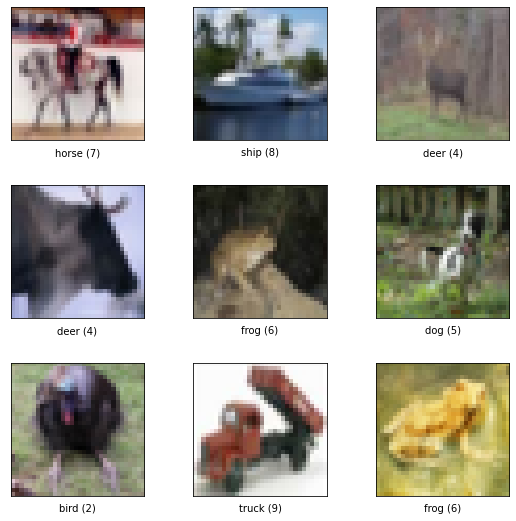

In [3]:
# some examples of images in dataset
tfds.show_examples(train_ds, ds_info)

In [4]:
# preprocessing

In [5]:
def preprocess_data(cifar):
    # convert data from uint8 to float32
    cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # input normalization, bringing image values from range [0, 255] to [-1, 1]
    cifar = cifar.map(lambda img, target: (tf.cast(tf.image.per_image_standardization(img), tf.float32), target))
    # target vectors (one-hot encoding) for 10 classes
    cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
                      
    # cache this progress in memory, as there is no need to redo it; it is deterministic after all
    cifar = cifar.cache()
    # shuffle, batch, prefetch
    cifar = cifar.shuffle(1000)
    cifar = cifar.batch(32)
    cifar = cifar.prefetch(20)
    
    # return preprocessed dataset
    return cifar

In [6]:
# pre-load some data
train_dataset = train_ds.apply(preprocess_data)
test_dataset = test_ds.apply(preprocess_data)

In [7]:
# visualize how the pre-processed data looks like
# Tensor with shape (batch-size, height, width, channels) for images 
# here: (32, 32, 32, 3)
# and Tensor with shape (batch-size, num_classes) for targets
# here: (32, 10)
iterator = iter(train_dataset)
iterator.get_next()

(<tf.Tensor: shape=(32, 32, 32, 3), dtype=float32, numpy=
 array([[[[-2.98136091e+00, -2.80640101e+00, -2.96192098e+00],
          [-1.52336204e+00, -8.23522568e-01, -1.32896221e+00],
          [-1.27064228e+00, -4.15282875e-01, -1.03736246e+00],
          ...,
          [-2.53424120e+00, -1.98992169e+00, -2.35928130e+00],
          [-2.68976116e+00, -2.10656166e+00, -2.51480126e+00],
          [-2.74808121e+00, -2.20376158e+00, -2.65088105e+00]],
 
         [[-2.82584095e+00, -2.47592139e+00, -2.76752114e+00],
          [-8.23522568e-01,  2.84556568e-01, -5.12482822e-01],
          [-3.95842910e-01,  9.45516050e-01, -6.53631538e-02],
          ...,
          [-9.98482466e-01,  5.12767583e-02, -6.87442660e-01],
          [-1.23176229e+00, -4.59231697e-02, -8.23522568e-01],
          [-1.44560206e+00, -2.98642963e-01, -1.07624233e+00]],
 
         [[-2.76752114e+00, -2.39816141e+00, -2.72864103e+00],
          [-7.65202641e-01,  4.59516436e-01, -4.93042827e-01],
          [-5.70802748e-

### 2.2 CNN Model 

* basic architecture

In [8]:
class CNN(tf.keras.Model):
    
    def __init__(self):
        
        super(CNN, self).__init__()
        
        # optimzer, metrics, loss
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.metrics_list = [
                        tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc") 
                       ]
        
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()   
        
        # layers
        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x
    
    # to reset metrics during training such that they don't accumulate every epoch
    def reset_metrics(self):
        
        for metric in self.metrics:
            metric.reset_states()
            
    # training and testing 
            
    @tf.function
    def train_step(self, data):
        
        x, targets = data
        
        # calculate and backpropagate gradients
        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            
            loss = self.loss_function(targets, predictions) + tf.reduce_sum(self.losses)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update loss metric
        self.metrics[0].update_state(loss)
        
        # update accuracy
        for metric in self.metrics[1:]:
            metric.update_state(targets,predictions)

        # Return a dictionary mapping metric names to current value to keep track of training
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        
        # same as in training but without backpropagating
        x, targets = data
        predictions = self(x, training=False)
        loss = self.loss_function(targets, predictions) + tf.reduce_sum(self.losses)
        # update loss metric
        self.metrics[0].update_state(loss)
        # update accuracy metric
        for metric in self.metrics[1:]:
            metric.update_state(targets, predictions)

        return {m.name: m.result() for m in self.metrics}


### 2.3 Training the network 

* hyperparameters
* loss function
* optimizer
* loss and accuracy for training and test data
* training loop with epochs = 15

In [9]:
def training_loop(model, train_ds, test_ds, epochs):
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        
        # Training:
        
        for data in train_ds:
            metrics = model.train_step(data)
            
        # save and print the metrics
        # this is very ugly and takes way too many computations but i don't want to use the tensorboard
        for (key, value) in metrics.items():
            if key == 'acc':
                train_accuracies.append(value.numpy())
            if key == 'loss':
                train_losses.append(value.numpy())
                
            print(f"{key}: {value.numpy()}")
        
        # reset all metrics 
        model.reset_metrics()    
        
        # Testing:
        for data in test_ds:
            metrics = model.test_step(data)
            
        for (key, value) in metrics.items():
            if key == 'acc':
                test_accuracies.append(value.numpy())
            if key == 'loss':
                test_losses.append(value.numpy())
                
            print(f"test_{key}: {value.numpy()}")
                    

        # reset all metrics
        model.reset_metrics()
        print("\n")
        
    return train_losses, train_accuracies, test_losses, test_accuracies

In [10]:
# initialize model
model = CNN()
# run training loop 
train_loss, train_acc, test_loss, test_acc = training_loop(model=model, 
                train_ds=train_dataset, 
                test_ds=test_dataset, 
                epochs=3 # should be 15 but my laptop is dying 
                )

Epoch 0:
loss: 1.6600075960159302
acc: 0.3867200016975403
test_loss: 1.4112117290496826
test_acc: 0.4950999915599823


Epoch 1:
loss: 1.284711480140686
acc: 0.5408200025558472
test_loss: 1.1582849025726318
test_acc: 0.5848000049591064


Epoch 2:
loss: 1.1281263828277588
acc: 0.601580023765564
test_loss: 1.064849615097046
test_acc: 0.6202999949455261




### 2.4 Visualization


In [11]:
def visualization(train_losses, train_accuracies, test_losses, test_accuracies ):
    plt.figure()
    line1, = plt.plot(train_losses , "b-")
    line2, = plt.plot(test_losses , "r-")
    line3, = plt.plot(train_accuracies , "b:")
    line4, = plt.plot(test_accuracies , "r:")

    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1 , line2 , line3 , line4), 
             ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

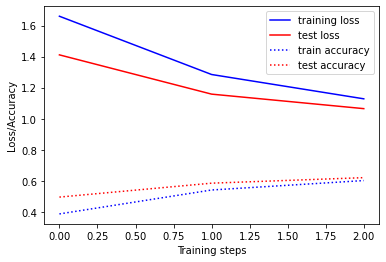

In [13]:
visualization(train_loss, train_acc, test_loss, test_acc)

## Assignment 3 Adjusting hyperparameters and architecture

* different combinations of layers 
* hyperparameters 
* optimizer 

### 3.1 Share results 